In [ ]:
import tensorflow as tf
class GhostModule(tf.keras.layers.Layer):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = int(oup // ratio)  # Ensure it's an integer
        new_channels = int(init_channels * (ratio - 1))

        self.primary_conv = tf.keras.Sequential([
            layers.Conv2D(init_channels, kernel_size, stride, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU() if relu else layers.Activation('linear'),
        ])

        self.cheap_operation = tf.keras.Sequential([
            layers.DepthwiseConv2D(dw_size, 1, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU() if relu else layers.Activation('linear'),
        ])

    def call(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = tf.concat([x1, x2], axis=-1)
        return out[:, :, :, :self.oup]

class TripletAttention(tf.keras.layers.Layer):
    def __init__(self, no_spatial=False, **kwargs):
        super(TripletAttention, self).__init__(**kwargs)
        self.no_spatial = no_spatial

    def channel_attention(self, x):
        x_perm = tf.transpose(x, perm=[0, 2, 1, 3]) 
        x_attn = tf.reduce_mean(x_perm, axis=1, keepdims=True)
        return tf.transpose(x_attn, perm=[0, 2, 1, 3])  

    def height_attention(self, x):
        x_perm = tf.transpose(x, perm=[0, 3, 2, 1])  # Swap height and channels
        x_attn = tf.reduce_mean(x_perm, axis=1, keepdims=True)
        return tf.transpose(x_attn, perm=[0, 3, 2, 1])  

    def spatial_attention(self, x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)

    def call(self, x):
        x_cw = self.channel_attention(x)
        x_hw = self.height_attention(x)
        x_sp = self.spatial_attention(x) if not self.no_spatial else 0

        # Combine attentions
        if not self.no_spatial:
            x = (x_cw + x_hw + x_sp) / 3.0
        else:
            x = (x_cw + x_hw) / 2.0
        return x



class NeighborhoodAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, num_heads=4, key_dim=None, attn_dropout=0.0, name=None):
        super().__init__(name=name)
        self.kernel_size = kernel_size
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

    def build(self, input_shape):
        channels = input_shape[-1]
        self.key_dim = self.key_dim or channels // self.num_heads
        self.qkv_layer = layers.Dense(self.num_heads * self.key_dim * 3)
        self.attn_dropout_layer = layers.Dropout(self.attn_dropout)
        self.output_layer = layers.Dense(channels)

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        qkv = self.qkv_layer(inputs)  # [batch, height, width, num_heads * key_dim * 3]
        qkv = tf.reshape(qkv, [-1, height * width, self.num_heads, 3 * self.key_dim])
        query, key, value = tf.split(qkv, 3, axis=-1)  # Split into Q, K, V
        query = tf.transpose(query, [0, 2, 1, 3])  # [batch, num_heads, height * width, key_dim]
        key = tf.transpose(key, [0, 2, 3, 1])      # [batch, num_heads, key_dim, height * width]
        attention_scores = tf.matmul(query, key) / tf.math.sqrt(float(self.key_dim))  # [batch, num_heads, height * width, height * width]
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_scores = self.attn_dropout_layer(attention_scores)
        value = tf.transpose(value, [0, 2, 1, 3])  # [batch, num_heads, height * width, key_dim]
        attention_output = tf.matmul(attention_scores, value)  # [batch, num_heads, height * width, key_dim]
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])  # [batch, height * width, num_heads, key_dim]
        attention_output = tf.reshape(attention_output, [batch_size, height, width, self.num_heads * self.key_dim])  # [batch, height, width, num_heads * key_dim]
        return self.output_layer(attention_output)
        
        


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_optimized_custom_cnn():
    input_layer = layers.Input(shape=(224, 224, 3))  # Correct usage of Input
    ghost1 = GhostModule(inp=3, oup=32, kernel_size=3)(input_layer)
    downsample = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ghost1)
    downsample_2 = layers.MaxPooling2D(pool_size=(2, 2))(downsample)
    nat = NeighborhoodAttention(kernel_size=3, num_heads=1, name="nat1")(downsample_2)  # Ensure NeighborhoodAttention is defined
    conv_layer_1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(nat)
    conv_layer_1 = layers.BatchNormalization()(conv_layer_1)
    global_avg_pool = layers.GlobalAveragePooling2D()(conv_layer_1)
    fc_layer_1 = layers.Dense(128, activation="relu")(global_avg_pool)
    fc_layer_1 = layers.BatchNormalization()(fc_layer_1)

    fc_layer_2 = layers.Dense(64, activation="relu")(fc_layer_1)
    fc_layer_2 = layers.BatchNormalization()(fc_layer_2)

    output_layer = layers.Dense(2, activation="softmax")(fc_layer_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Instantiate and summarize the model
optimized_custom_cnn_model = create_optimized_custom_cnn()
optimized_custom_cnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 ghost_module (GhostModule)  (None, 224, 224, 32)      704       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 nat1 (NeighborhoodAttention  (None, 56, 56, 32)       4224      
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496 

In [14]:
# Specify the path to your weights file
weights_path = r"E:\Projects\Content-moderation\weights\custom_cnn_model.hdf5"

# Load the weights into the model
optimized_custom_cnn_model.load_weights(weights_path)

# Verify the model has loaded the weights
print("Weights loaded successfully.")


Weights loaded successfully.


In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the test data directory
test_data_path = r"E:\Projects\Content-moderation\out\test"

# Define image parameters
image_size = (224, 224)  # Should match the model input size
batch_size = 32          # Batch size for loading images
class_names = ["Neutral", "NSFW"]  # Replace with your actual class labels

# Load the test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Do not shuffle to match predictions with filenames
)

# Get true labels
true_labels = test_generator.classes

# Predict using the model
predictions = optimized_custom_cnn_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)



Found 5547 images belonging to 2 classes.
174/174 [==============================] - 317s 2s/step


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.89      0.96      0.92      3351
        NSFW       0.93      0.82      0.87      2196

    accuracy                           0.90      5547
   macro avg       0.91      0.89      0.90      5547
weighted avg       0.91      0.90      0.90      5547



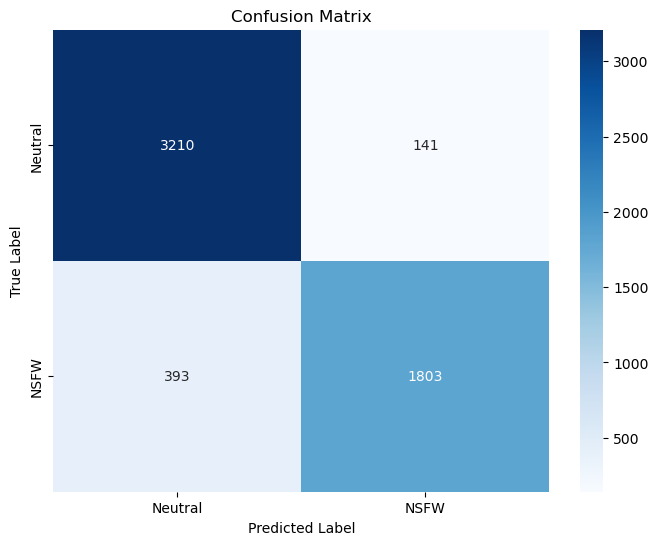

In [18]:
# Generate classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


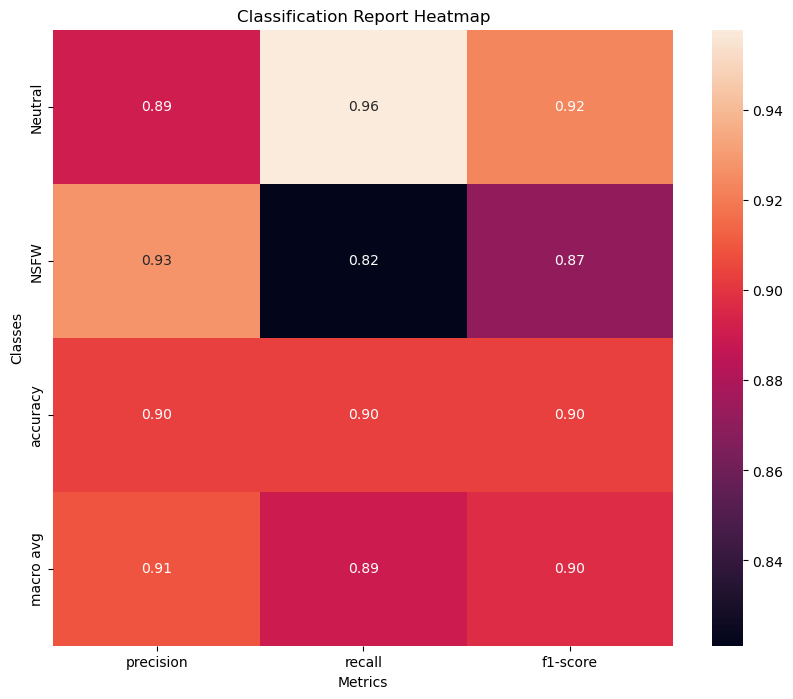

In [19]:
import pandas as pd
report = classification_report(true_labels, predicted_classes, target_names=class_names,output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(
    report_df.iloc[:-1, :-1],  # Exclude support row and accuracy column
    annot=True,  
    fmt=".2f"
)
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()